# 互评作业2: 频繁模式与关联规则挖掘

In [2]:
from scipy.stats import chi2_contingency
from akapriori import apriori
import numpy as np 
import pandas as pd 

In [3]:
csv = pd.read_csv('/kaggle/input/wine-reviews/winemag-data-130k-v2.csv')
df =csv.dropna()
df.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


## 一、数据集预处理
选取points、price、country、winery这两种数值属性和标称属性。  
### 1、对数值属性points和price概念分层(离散化)。

In [4]:
numeric = ['points', 'price']
df2 = df[numeric]
df2 = df2.loc[:,~df2.columns.str.contains('^Unnamed')]
df2.describe()[-5:]

,points,price
min,80.0,4.0
25%,88.0,25.0
50%,90.0,36.0
75%,92.0,50.0
max,100.0,2013.0


以points和price属性的五数分布为依据，将points和price属性的{x|x<q1}、{x|q1<x<q3}和{x|x>q4}分别离散化为3个取值——{高分，中分，低分}和{高价，平价，低价}。

In [5]:
interval1 = [0,80,90,92,101]
interval2 = [0,25,36,50,2014]
df.loc[:,'points'] = pd.cut(df2.points, interval1,labels=['lowP','midP1','midP2','highP'])
df.loc[:,'price'] = pd.cut(df2.price, interval2,labels=['lowC','midC1','midC2','highC'])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
df['points'][:2]

4     midP1
10    midP1
Name: points, dtype: category
Categories (4, object): [lowP < midP1 < midP2 < highP]

In [7]:
df['price'][:2]

4     highC
10     lowC
Name: price, dtype: category
Categories (4, object): [lowC < midC1 < midC2 < highC]

In [8]:
transactions = []
for index, row in df.iterrows():
    transactions += [(row['points'], row['price'], row['country'], row['winery'])]
transactions[:2]

[('midP1', 'highC', 'US', 'Sweet Cheeks'),
 ('midP1', 'lowC', 'US', 'Kirkland Signature')]

## 二、找出频繁模式
以支持度和置信度阈值分别为0.009和0.06为例。

In [11]:
rules = apriori(transactions, support=0.1, confidence=0.1)

In [12]:
import csv as cs
with open('result.csv', 'wt') as f:
    f_csv = cs.writer(f, delimiter=',')
    f_csv.writerow(['rules', 'support', 'confidence', 'lift'])
    for r in rules:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])
pd.read_csv('result.csv')

,rules,support,confidence,lift
0,midP1 => lowC,0.247376,0.408287,1.435576
1,lowC => midP1,0.247376,0.869797,1.435576
2,midC1 => midP1,0.159870,0.693470,1.144553
3,midP1 => midC1,0.159870,0.263860,1.144553


求得4个关联规则及其支持度和置信度(上表)

### 2、求规则支持度、置信度和卡方检验  
其中支持度、置信度已经在上表中求得

In [22]:
from  scipy import stats
import numpy as np

In [24]:
def colu(df,col):
    uni = df[col].unique().tolist()
    return uni
def observe(df,subcol,maincol):
    d = []
    lst1 = colu(df,subcol)
    lst2 = colu(df,maincol)
    for l in lst1:
        for ls in lst2:
            b = len(df[(df[subcol] == l)&(df[maincol]==ls)])
            d.append(b)
    return d
def split_array(df,subcol,maincol):
    result_lst = []
    lst = observe(df,subcol,maincol)
    for j in range(0,len(lst),len(colu(df,maincol))):
        result = lst[j:j+len(colu(df,maincol))]
        result_lst.append(result)
    result_lst = np.array(result_lst)
    return result_lst.T
def chi(array):
    #计算理论值
    #main = np.sum(array,axis=1)
    #sub = np.sum(array,axis=0)
    sum_ = np.sum(np.sum(points_price))
    #理论值:
    #expectation_value = sum_*(main/np.sum(main))*(sub/np.sum(sub))
    #expectation_value1 = sum_*(1-main/np.sum(main))*(sub/np.sum(sub))
    if sum_ > 40:
        print('样本量大于40')
        chi,p,v,exp = stats.chi2_contingency(array,correction=False)
    else:
        print('样本量小于40')
        chi,p,v,exp = stats.chi2_contingency(array,correction=True)
    print ('''
====================================================
报告
χ2值:{}
p值:{}
自由度:{}
理论值:
{}
====================================================
      '''.format(chi,p,v,exp))
    if p > 0.05:
        print('不拒绝原假设,无充分证据表明两个因素之间存在关系')
    else:
        if p < 0.05:
            print('显著性水平α=0.05下,拒绝原假设,充分相关')
        elif p < 0.01:
            print('显著性水平α=0.01下,拒绝原假设,显著相关')
    return (chi,p,v,exp)

In [25]:
points_price  = split_array(df,'points','price')
chi(points_price)

样本量大于40

报告
χ2值:4989.547886289448
p值:0.0
自由度:9
理论值:
[[3145.16120963 1272.53352392  766.81274847    6.49251798]
 [3857.68472774 1560.82083352  940.53106714    7.9633716 ]
 [3434.16947336 1389.46638674  837.27502568    7.08911422]
 [3126.98458927 1265.17925582  762.38115871    6.4549962 ]]
      
显著性水平α=0.05下,拒绝原假设,充分相关


(4989.547886289448,
 0.0,
 9,
 array([[3145.16120963, 1272.53352392,  766.81274847,    6.49251798],
        [3857.68472774, 1560.82083352,  940.53106714,    7.9633716 ],
        [3434.16947336, 1389.46638674,  837.27502568,    7.08911422],
        [3126.98458927, 1265.17925582,  762.38115871,    6.4549962 ]]))

故卡方检验的结论是price属性和points属性显著相关

## 三、挖掘结果分析  
挖掘结果表明price属性和points属性显著相关，并且有midP1 => lowC等4个关联规则。然而并没有发现包含country和winery的关联规则，可能原因是price和points属性相关相对更强，导致在当前阈值设定下包含country和winery的关联规则没有被筛选出来。  
从数据库角度的属性描述分析，price和points属性之间的关联规则是合理的

## 四、可视化分析  
为了可视化关联规则的置信度和支持度，我们下调支持度和置信度阈值

In [28]:
rules = apriori(transactions, support=0.01, confidence=0.01)
with open('result2.csv', 'wt') as f:
    f_csv = cs.writer(f, delimiter=',')
    f_csv.writerow(['rules', 'support', 'confidence', 'lift'])
    for r in rules:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])
c2 = pd.read_csv('result2.csv')

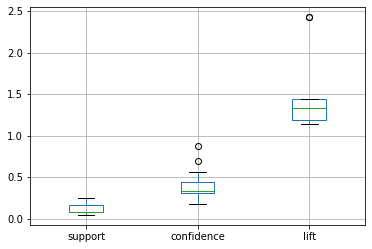

In [30]:
import matplotlib.pyplot as plt
c2[['support','confidence','lift']].boxplot()
plt.tight_layout()